ocroline
========

An LSTM/CTC-based text line recognizer for printed text.

In [7]:
%pylab inline
rc("image", cmap="gray", interpolation="bicubic")

Populating the interactive namespace from numpy and matplotlib


In [28]:
!test -f line2-000003330-004377.pt || wget --quiet -nd http://storage.googleapis.com/tmb-models/line2-000003330-004377.pt

# Line Recognition

The `LineRecognizer` class wraps up the line recognizer in a small, simple-to-use class.

This class will always perform line normalization on its input.

It can also perform batching of multiple lines if you want to recognize multiple lines together.

In [29]:
import ocroline
rec = ocroline.LineRecognizer("line2-000003330-004377.pt")
rec.model

Sequential(
  (0): Reorder BHWD->BDHW
  (1): CheckSizes [(0, 900), (1, 1), (48, 48), (0, 9000)]
  (2): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True)
  (4): ReLU()
  (5): MaxPool2d(kernel_size=(2, 1), stride=(2, 1), dilation=(1, 1), ceil_mode=False)
  (6): Conv2d(100, 200, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (7): BatchNorm2d(200, eps=1e-05, momentum=0.1, affine=True)
  (8): ReLU()
  (9): Reshape((0, [1, 2], 3))
  (10): CheckSizes [(0, 900), (0, 5000), (0, 9000)]
  (11): LSTM1:LSTM(4800, 200, bidirectional=1)
  (12): Conv1d(400, 97, kernel_size=(1,), stride=(1,))
  (13): Reorder BDW->BWD
  (14): CheckSizes [(0, 900), (0, 9000), (97, 97)]
)

Continuum Mechanics


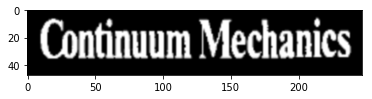

In [30]:
imshow(sample["png"])
print rec.recognize_line(sample["png"])

# Training

Training files are just tar files containing `.png` and corresponding `.txt` files with the ground truth.

In [6]:
%%bash
tar -ztvf testdata/testlines.tgz | sed 6q

-rw-rw-r-- tmb/tmb           1 2018-03-24 23:57 000000.index
-rw-rw-r-- tmb/tmb        1470 2018-03-24 23:57 000000.png
-rw-rw-r-- tmb/tmb          19 2018-03-24 23:57 000000.txt
-rw-rw-r-- tmb/tmb           1 2018-03-24 23:57 000001.index
-rw-rw-r-- tmb/tmb         424 2018-03-24 23:57 000001.png
-rw-rw-r-- tmb/tmb           3 2018-03-24 23:57 000001.txt


tar: write error


Continuum Mechanics


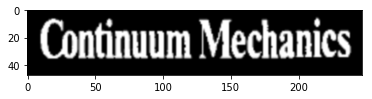

In [8]:
from dlinputs import tarrecords
sample = tarrecords.tariterator(open("testdata/testlines.tgz")).next()
print sample["txt"]
imshow(sample["png"])

The training data for the line recognizer needs to be sized normalized. You can use the functions in `lineest.CenterLineNormalizer` for that. In this training set, the data is already normalized.

The `CenterNormalizer`:

- removes some rotation and size variation
- resizes the image to a final height of 48 pixels

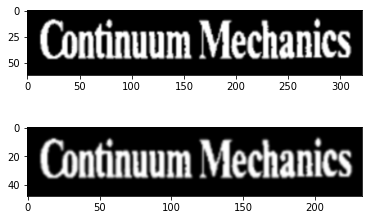

In [24]:
from ocroline import lineest
cn = lineest.CenterNormalizer()
image = ndi.zoom(sample["png"], 1.3, order=1)
normalized = cn.measure_and_normalize(image)
subplot(211); imshow(image)
subplot(212); imshow(normalized)

In [5]:
%%bash
ocroline-train -d testdata/testlines.tgz -t testdata/testlines.tgz -T 100 -o testmodel --epochs 1

['CenterNormalizer', 'LineRecognizer', '__builtins__', '__doc__', '__file__', '__name__', '__package__', '__path__', 'lineest', 'recognizer']
__key__ <type 'list'> ['000006', '000007', '000008', '000009', '000010']
__source__ <type 'list'> ['testdata/testlines.tgz', 'testdata/testlines.tgz', 'testda
_bucket 12
image float64 (5, 48, 1295, 1)
transcript float64 (5, 159, 97)
input (3L, 48L, 20L, 1L)
output (3L, 20L, 97L)
Sequential(
  (0): Reorder BHWD->BDHW
  (1): CheckSizes [(0, 900), (1, 1), (48, 48), (0, 9000)]
  (2): Conv2d(1, 100, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Reshape((0, [1, 2], 3))
  (5): CheckSizes [(0, 900), (0, 5000), (0, 9000)]
  (6): LSTM1:LSTM(4800, 100, bidirectional=1)
  (7): Conv1d(200, 97, kernel_size=(1,), stride=(1,))
  (8): Reorder BDW->BWD
  (9): CheckSizes [(0, 900), (0, 9000), (97, 97)]
)
# 5
TRU body fill a region in a four-dimensional Preisach space. A thermodynamical
ALN 
PRE Z
testset 100 1.0
saving as testmodel-0000000

# Naming Convention

All models are saved as 

`prefix-000000000-000000.pt`

- first number: # training samples used for training (in thousands)
- second number is the error rate times one million.

# LSTM Based Text Line Recognition

currently:
- high performance, low error rate for printed text
- relies on hardcoded size normalization
- fairly simple and fast models (due to normalization)

future:
- try to automate size normalization
- semi-supervised and self-supervised training
- integrate with segmentation
- move to more human-like reading models (probably much slower)